# Банки — Анализ оттока клиентов

<b>Заказчик:</b> отдел маркетинга регионального банка.<br>
<b>Цель работы:</b> в банке повысился отток, и с этим нужно что-то делать.<br>
<b>Ретроспектива:</b> ранее было проведено исследование оттока, составлены дэшборды и выделены сегменты, но клиентская база поменялась, и текущие решения не работают.<br>
<b>Конечный результат:</b> выделены отточные сегменты, даны рекомендации по снижению оттока.

## Цель проекта

Проанализировать клиентов регионального банка и выделить сегменты клиентов, которые склонны уходить из банка.<br>
Приоритизировать сегменты и сформировать рекомендации для отдела маркетинга по работе с ними.

## Проект

In [1]:
# в данную ячейку будем добавлять библиотеки по мере их необходимости
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from scipy import stats as st
plt.rcParams ['figure.figsize'] = [12, 8]

### Загрузка и знакомство с данными

Датасет содержит данные о клиентах регионального банка. Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

In [2]:
try:
    df = pd.read_csv('C:/Users/Student/Desktop/bank_scrooge.csv')
except:
    df = pd.read_csv('https://drive.google.com/drive/datasets/bank_scrooge.csv')

In [3]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


<b>userid</b> — идентификатор пользователя<br>
<b>score</b> — баллы кредитного скоринга<br>
<b>city</b> — город<br>
<b>gender</b> — пол<br>
<b>age</b> — возраст<br>
<b>equity</b> — количество баллов собственности<br>
<b>balance</b> — баланс на счёте<br>
<b>products</b> — количество продуктов, которыми пользуется клиент<br>
<b>credit_card</b> — есть ли кредитная карта<br>
<b>last_activity</b> — активный клиент<br>
<b>est_salary</b> — заработная плата клиента<br>
<b>churn</b> — ушёл или нет

### Предобработка данных

#### Наименование колонок

Приведем названия столбцов к нижнему регистру для удобства их дальнейшего использования.

In [4]:
df.columns = df.columns.str.lower()
df.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

#### Пропущенные значения

Общепринятая классификация пропусков:
- MCAR (Missing Completely At Random / Отсутствует совершенно случайно) — пропуски не зависят от переменных и не ведут к систематической ошибке (смещение, bias), но увеличивают случайную ошибку (разброс, variance), можно их отбрасывать или заполнять, т.к. заполнение не повлияет на характер связи между заполняемой переменной и остальными;
- MAR (Missing At Random / Отсутствует случайно) — в рамках каждой из групп, которая есть в описываемой данными совокупности, распределение пропусков случайно, можно их отбрасывать;
- MNAR (Missing Not At Random / Отсутствует не случайно) — пропуски зависят от данных, без дополнительного обоснования их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.
        
    Перед обработкой пропусков обязательно стоит выяснить, к какому типу они относятся, а также как эти пропуски зависят от имеющихся данных - тогда можно будет выбрать более удачную стратегию работы с ними.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   userid         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Поделим сумму нулевых значений столбца "возраст" на общее число строк в датафрейме.

In [6]:
print(f"{df['age'].isna().sum() / df['age'].count():.2%}") 

0.26%


Для дальнейшего исследования возраст - довольно показательный фактор, а заполнить подобные пропущенные значения не представляется возможным. Скорее всего данные пропуски относятся к типу MAR и с учетом того, что таких клиентов в датафрейме крайне немного, считаю, что их можно удалить. 

In [7]:
df = df.dropna(subset = ['age']) 
df = df.reset_index(drop=True) #обновим индексы

Посмотрим как отличаются между собой меры центральной тенденции для столбца баланса - для этого создадим дополнительный столбец с признаком наличия пропуска в колонке с балансом.

In [8]:
def balance_pass(row):
    """
    Возвращает:
    -  1 если в наблюдении есть пропуск в балансе
    -  0 если в наблюдении баланс заполнен
    """
    pass 
    
    b = row['balance']
    
    if b >= 0 or b <0 :
        return 0
 
    return 1

df['balance_pass'] = df.apply(balance_pass, axis=1)
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_pass
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1,0
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0,1
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1,0
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1,0


Посмотрим на зависимость пропусков в балансе от непрерывных признаков.

In [9]:
balance_trends1 = df.groupby('balance_pass').agg({'score' : ['mean', 'median'],
                                     'age' : ['mean', 'median'],
                                     'est_salary' : ['mean', 'median']
                                   }).round(2).transpose()
balance_trends1.columns = ['balance_indicated', 'no_balance']
balance_trends1['difference'] = (balance_trends1['no_balance'] - balance_trends1['balance_indicated']).round(2)
balance_trends1

balance_indicated  no_balance  difference
score      mean               843.74      865.36       21.62
           median             840.00      903.00       63.00
age        mean                42.92       42.09       -0.83
           median              40.00       40.00        0.00
est_salary mean            124520.39   226345.42   101825.03
           median          106250.18   174347.87    68097.69

Теперь посмотрим на категориальные признаки.

In [10]:
balance_trends2 = df.groupby('balance_pass').agg({'city' : pd.Series.mode,
                                     'gender' : pd.Series.mode,
                                     'equity' : 'median',
                                     'products' : 'median',
                                     'credit_card' : 'median',
                                     'last_activity' : 'median'
                                   }).transpose()
balance_trends2.columns = ['balance_indicated', 'no_balance']
balance_trends2

,balance_indicated,no_balance
city,Ярославль,Ярославль
gender,Ж,М
equity,4,0
products,2,1
credit_card,1,1
last_activity,1,1


Похоже, что баланс не указан в случае 0 баллов собственности у клиента. Проверим дополнительно.

In [11]:
print("Количество клиентов с 0 баллами собственности и отсутствующим балансом: "
    f"{df.query('equity == 0 & balance_pass == 1')['userid'].count()}.")
perc = (df.query('equity == 0 & balance_pass == 1')['userid'].count() 
    / df.query('balance_pass == 1')['userid'].count() * 100)
print("Что составляет "
    f"{perc.round(2)}"
    "% от общего числа клиентов с неуказанным балансом.")

Количество клиентов с 0 баллами собственности и отсутствующим балансом: 2164.
Что составляет 94.95% от общего числа клиентов с неуказанным балансом.


Теперь с уверенностью можно сказать, что данные пропуски относятся к типу MNAR и их нельзя отбрасывать или заполнять одним значением, т.к. это приведёт к заметным искажениям.

#### Соответствие типов данных

Преобразуем столбец с возрастом в целые числа.

In [12]:
df['age'] = df['age'].astype(int)

Проверим какие значения в себе содержит столбец с баллами кредитного скоринга.

In [13]:
df['score'].unique()

array([ 850.,  861.,  892.,  866.,  730.,  856.,  807.,  825.,  923.,
        906.,  927.,  921.,  845.,  837.,  815.,  731.,  829.,  793.,
        876.,  922.,  772.,  896.,  871.,  732.,  898.,  806.,  766.,
        776.,  868.,  946.,  828.,  786.,  944.,  863.,  822.,  794.,
        924.,  811.,  814.,  956.,  935.,  826.,  849.,  901.,  893.,
        792.,  888.,  831.,  748.,  820.,  860.,  914.,  930.,  948.,
        789.,  737.,  812.,  933.,  809.,  749.,  873.,  859.,  950.,
        937.,  835.,  768.,  767.,  785.,  846.,  750.,  816.,  894.,
        891.,  788.,  758.,  787.,  821.,  855.,  779.,  791.,  838.,
        971.,  797.,  841.,  915.,  985.,  870.,  897.,  763.,  774.,
        686., 1000.,  875.,  819.,  869.,  854.,  810.,  761.,  802.,
        958.,  917.,  745.,  736.,  908.,  928.,  884.,  853.,  780.,
        726.,  881.,  975.,  852.,  965.,  899.,  890.,  836.,  818.,
        880.,  795.,  916.,  775.,  902.,  918.,  842.,  771.,  895.,
        801.,  721.,

Также преобразуем в целые числа.

In [14]:
df['score'] = df['score'].astype(int)

#### Дубликаты

Сперва проверим явные дубликаты.

In [15]:
df.duplicated().sum()

0

Проверим также содержание колонок, которые могли повлиять на возникновение неявных дубликатов.

In [16]:
df['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [17]:
df['gender'].unique()

array(['Ж', 'М'], dtype=object)

Здесь все в порядке.

In [18]:
df['userid'].duplicated().sum()

50

Найдено 50 дубликатов по идентификатору пользователя. Посмотрим что они из себя представляют и нужно ли от них избавляться.

In [19]:
pd.set_option('display.max_rows', None)
df[df.duplicated(subset='userid',keep=False)].sort_values(by='userid')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_pass
1892,116540,883,Рыбинск,Ж,55,1,362756.49,3,0,1,175920.48,1,0
7683,116540,887,Ярославль,Ж,38,0,NaN,1,0,1,119247.61,0,1
4862,117943,855,Рыбинск,Ж,32,6,1036832.93,4,1,1,107792.71,1,0
7531,117943,880,Ярославль,Ж,40,0,NaN,1,1,0,137718.93,0,1
5856,120258,908,Рыбинск,Ж,38,4,2213581.63,2,0,1,160327.77,1,0
5889,120258,905,Ярославль,М,30,0,NaN,1,1,1,146427.96,0,1
1410,123461,829,Ярославль,Ж,59,0,96222.44,2,0,1,102771.55,1,0
8621,123461,934,Рыбинск,М,34,0,NaN,2,1,0,291619.27,0,1
9750,124450,758,Рыбинск,Ж,36,0,73574.07,2,0,1,79963.59,0,0
8151,124450,859,Ярославль,Ж,38,6,516811.20,1,1,1,95144.63,1,0


Похоже, проблема идентификаторов в том, что в Ярославле и Рыбинске они могут совпадать и поэтому задваиваются. Но это совершенно точно разные клиенты, а сами идентификаторы в дальнейшем нам не помешают, так что оставим все как есть.

Посмотрим есть ли аномальные пользователи с нулевым количеством продуктов.

In [20]:
df.query('products == 0')

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_pass
8939,147837,962,Рыбинск,Ж,79,3,NaN,0,0,0,25063.96,1,1


Удалим.

In [21]:
df = df[df['products'] != 0]

#### Кодирование переменных

К категориальному неупорядоченныму "гендер" применим one-hot кодирование при помощи `pandas.get_dummies()`. Чтобы при этом не потерять оригинальный столбец, сделаем его копию и используем параметр <tt>columns</tt>.

In [22]:
df['cod_gender'] = df['gender']
df = pd.get_dummies(df, columns=['cod_gender'], drop_first=True)
df.head()

,userid,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_pass,cod_gender_М
0,183012,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1,0,0
1,146556,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0,0,0
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0,1,0
3,225363,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1,0,0
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1,0,1


P.S. далее кодирование мною не использовано. Я бы удалила этот пункт.

### Исследовательский анализ данных

#### Анализ распределения признаков

Проверим общее распределение признаков по всем клиентам банка и составим портрет среднестатистического клиента. Данный пункт сделаем крупными мазками, а более детально признаки будем изучать уже в следующем пункте в разрезе оттока.

In [23]:
df.describe().round(2)

,userid,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,balance_pass,cod_gender_М
count,9973.00,9973.00,9973.00,9973.00,7.695000e+03,9973.00,9973.00,9973.00,9973.00,9973.00,9973.00,9973.0
mean,171757.62,848.67,42.73,2.63,8.272456e+05,1.87,0.68,0.52,147799.12,0.18,0.23,0.5
std,33696.37,65.39,12.18,1.98,1.980327e+06,0.79,0.47,0.50,139287.08,0.39,0.42,0.5
min,94561.00,642.00,18.00,0.00,0.000000e+00,1.00,0.00,0.00,2546.30,0.00,0.00,0.0
25%,142757.00,802.00,33.00,0.00,2.956987e+05,1.00,0.00,0.00,75252.02,0.00,0.00,0.0
50%,172651.00,853.00,40.00,3.00,5.242953e+05,2.00,1.00,1.00,119643.06,0.00,0.00,1.0
75%,201164.00,900.00,51.00,4.00,9.800512e+05,2.00,1.00,1.00,174499.96,0.00,0.00,1.0
max,229145.00,1000.00,86.00,9.00,1.191136e+08,5.00,1.00,1.00,1395064.45,1.00,1.00,1.0


Для непрерывных признаков посмотрим на среднее и медиану: типичный клиент имеет около 850 баллов кредитного скоринга, его возраст около 40 лет, а зарплата где-то 148 000 у.е. (медианное значение 120 000 у.е.).<br>
Глядя на дискретные признаки можно также сказать, что у такого клиента около 3х баллов собственности, 2 продукта в банке и есть кредитная карта.

#### Значимые признаки отточности

- для непрервных признаков: найдем отточные интервалы, т.е. на которых отток выше, чем лояльность;
- для категориальных/дискретных признаков: найдем какое из значений категориального признака более или менее склонно к оттоку. 

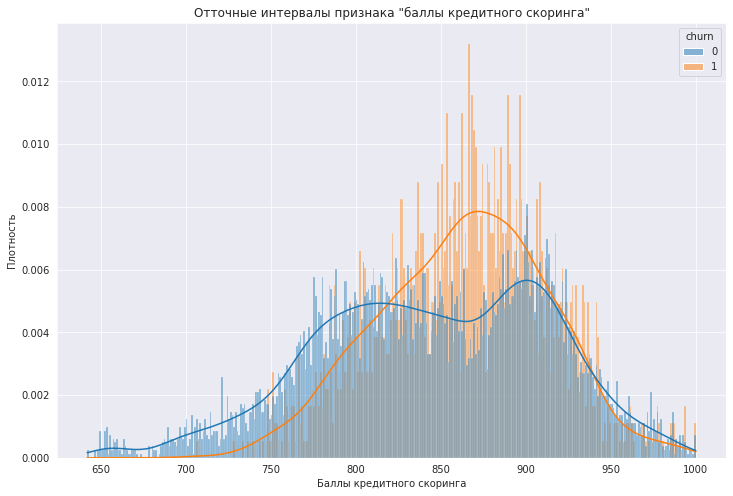

In [24]:
sns.set_style('darkgrid')
sns.histplot(data=df, x='score', hue='churn', stat="density", 
             binwidth=1, common_norm=False, kde=True, alpha=0.5)
plt.title('Отточные интервалы признака "баллы кредитного скоринга"')
plt.xlabel('Баллы кредитного скоринга')
plt.ylabel('Плотность');

Глядя на график можно сказать, что клиенты с баллами кредитного скоринга 820-900 более склонны уйти из банка, чем оставаться в нем. А самые лояльные клиенты - люди с баллами менее 820.

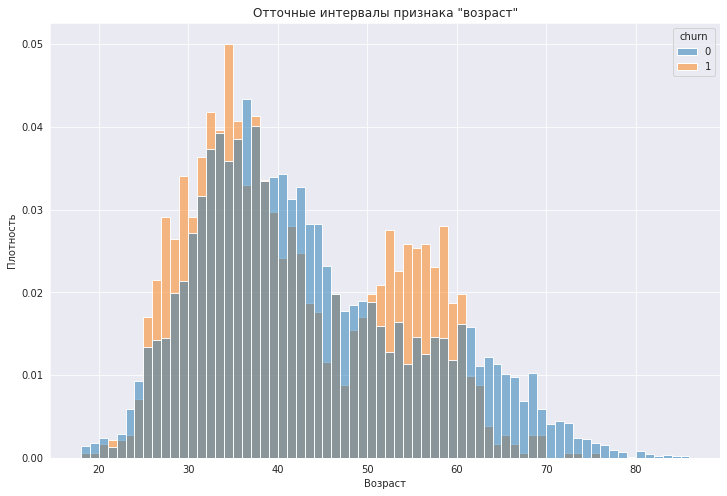

In [25]:
sns.histplot(data=df, x='age', hue='churn', stat="density", 
             binwidth=1, common_norm=False, alpha=0.5)
plt.title('Отточные интервалы признака "возраст"')
plt.xlabel('Возраст')
plt.ylabel('Плотность');

Клиенты в возрасте 25-36 лет, а также в возрасте 50-61 года более склонны уйти из банка, чем клиенты других возрастов.

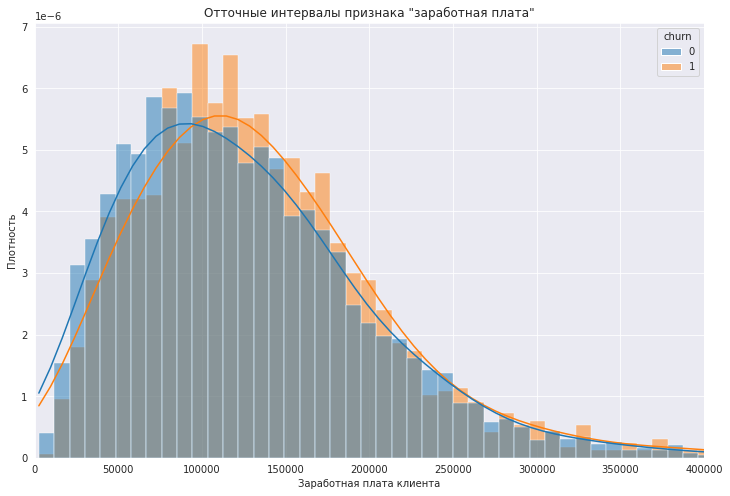

In [26]:
sns.histplot(data=df, x='est_salary', hue='churn', stat="density", 
             common_norm=False, kde=True, alpha=0.5)
# здесь ограничим ось X
plt.xlim(0, 400000)
plt.title('Отточные интервалы признака "заработная плата"')
plt.xlabel('Заработная плата клиента')
plt.ylabel('Плотность');

Клиенты с заработной платой менее 100 000 у.е. в среднем более лояльны, чем клиенты с заработной платой более 100 000 у.е. После отметки в 200 000 у.е. поведение уже непредсказуемо.

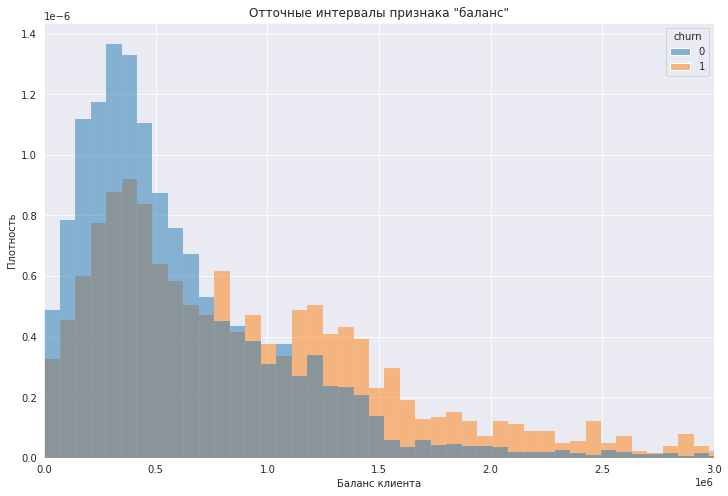

In [27]:
sns.histplot(data=df, x='balance', hue='churn', stat="density", 
             common_norm=False, alpha=0.5)
# здесь ограничим ось X
plt.xlim(0, 3000000)
plt.title('Отточные интервалы признака "баланс"')
plt.xlabel('Баланс клиента')
plt.ylabel('Плотность');

Клиенты с балансом менее 750 000 у.е. в основном остались, затем тенденция начинает меняться и мы видим, что клиенты с балансом более 750 000 у.е. - скорее ушли.

Далее построим графики для дискретных признаков, передав параметру `x` анализируемый признак, а параметру `y` - признак оттока. А также обозначим средний уровень оттока - по нему мы будем определять, что значение признака более склонно к оттоку (если уровень оттока признака выше, чем в среднем по банку - считаем, что признак влияет сильно).

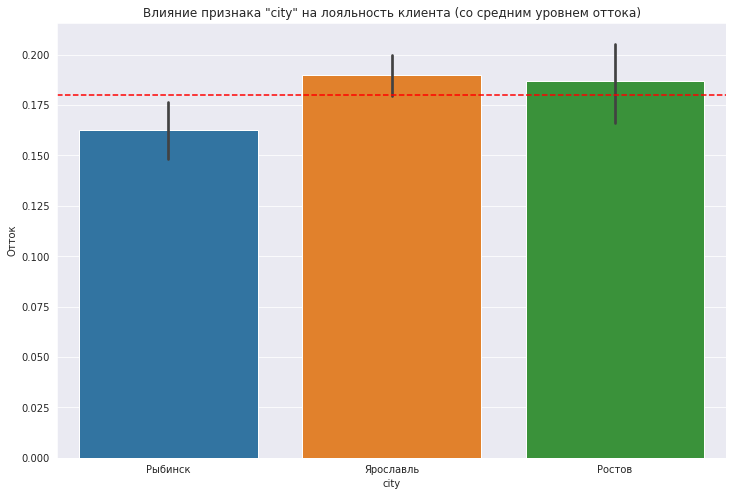

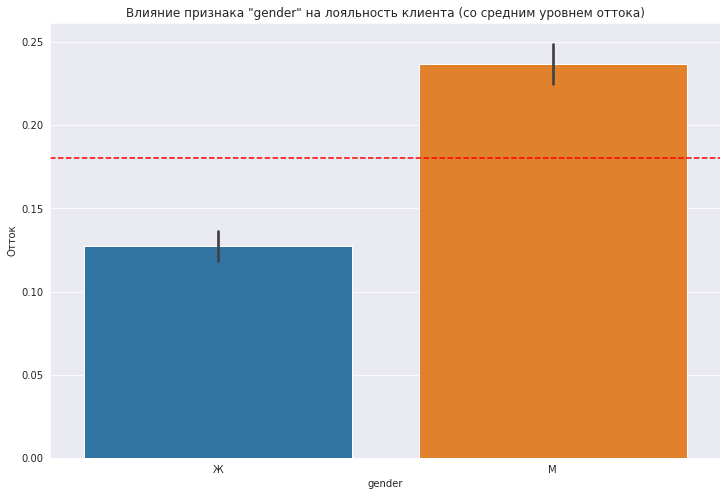

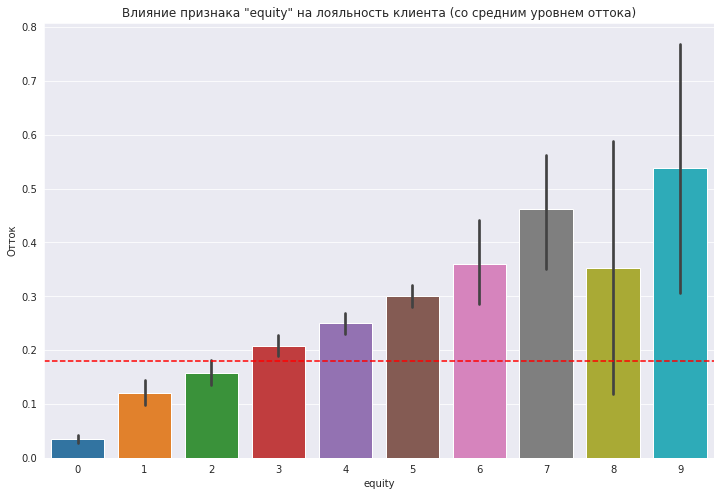

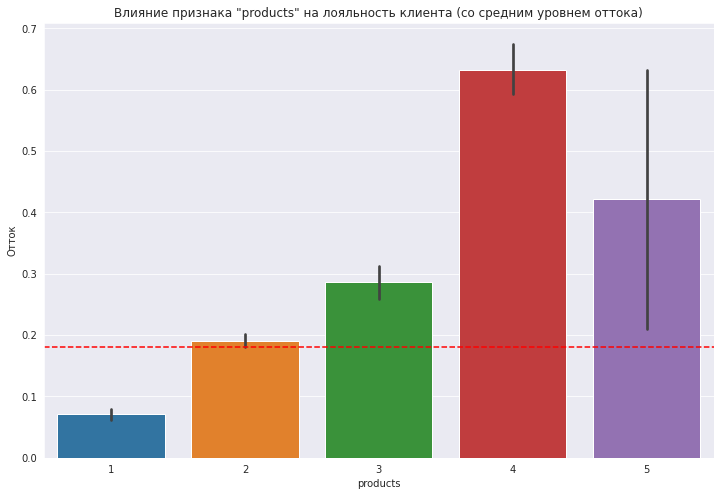

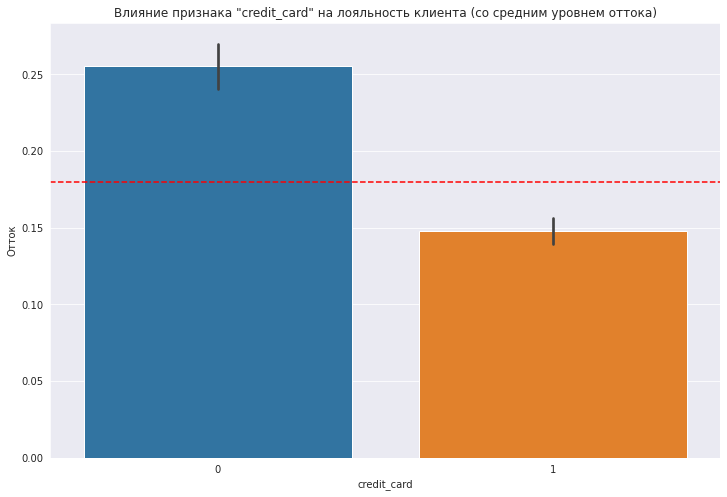

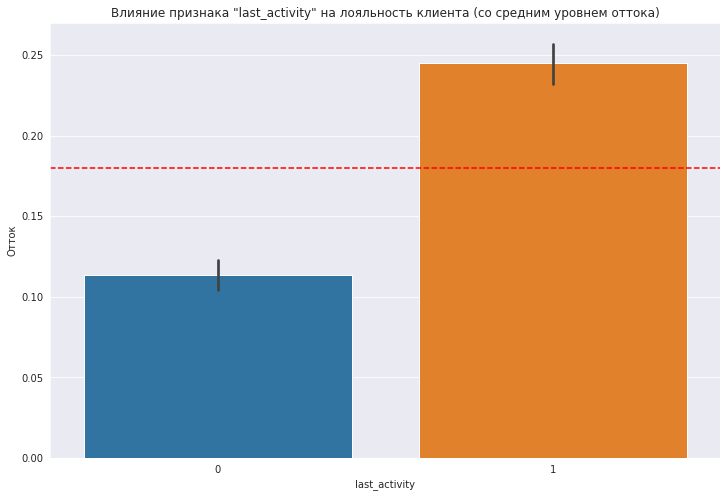

In [28]:
for k in ['city', 'gender', 'equity', 'products', 'credit_card', 'last_activity']:
    ax = sns.barplot(x=k, y='churn', data=df)
    plt.axhline(y=0.18, color='red', linestyle='--')
    plt.title(f'Влияние признака "{k}" на лояльность клиента (со средним уровнем оттока)')
    plt.xlabel(k)
    plt.ylabel('Отток')
    plt.show()

- Влияние признака "город" можно считать неярко выраженным;
- Мужчины более склонны уходить из банка, чем женщины, и чем в среднем по банку;
- Клиенты с 3 баллами собственности и более - также в зоне оттока больше среднего, причем чем больше баллов собственности - тем больше вероятность потери клиента;
- Чем меньшее количество продуктов банка использует клиент - тем он лояльнее (исключение: клиент с 5 продуктами лояльнее клиента с 4);
- Пользователь без кредитной карты имеет больше шансов покинуть банк;
- Активные клиенты имеют склонность уходить из банка, так они пользуются услугами и принимают решения, тогда как неактивные пользователи это либо те же пользователи, что уже давно ушли, либо те, что давно не пользуются услугами, но и не считают необходимым уходить из банка.

#### Сравнение портретов 

Сравним портреты типичных клиентов, которые склонны и не склонны уходить из банка.

Посмотрим на непрерывне признаки и посчитаем для них относительную разницу.

In [29]:
portrait1 = df.groupby('churn').agg({'score' : ['mean', 'median'],
                                     'age' : ['mean', 'median'],
                                     'est_salary' : ['mean', 'median'],
                                     'balance' : ['mean', 'median']
                                   }).round(2).transpose()
portrait1.columns = ['loyal', 'outflow']
portrait1['difference'] = (portrait1['outflow'] - portrait1['loyal']).round(2)
portrait1

loyal     outflow  difference
score      mean       845.40      863.36       17.96
           median     848.00      866.00       18.00
age        mean        43.02       41.43       -1.59
           median      40.00       39.00       -1.00
est_salary mean    147674.64   148357.48      682.84
           median  118227.60   125408.88     7181.28
balance    mean    733031.63  1134458.21   401426.58
           median  475410.09   783908.90   308498.81

Теперь посмотрим на дискретные.

In [30]:
portrait2 = df.groupby('churn').agg({'city' : pd.Series.mode,
                                     'gender' : pd.Series.mode,
                                     'equity' : 'median',
                                     'products' : 'median',
                                     'credit_card' : 'median',
                                     'last_activity' : 'median'
                                   }).transpose()
portrait2.columns = ['loyal', 'outflow']
portrait2

,loyal,outflow
city,Ярославль,Ярославль
gender,Ж,М
equity,3,4
products,2,2
credit_card,1,1
last_activity,0,1


Можно сделать выводы по результатам сравнения портретов:
- Баллов кредитного скоринга у ушедших клиентов немного больше, чем у оставшихся;
- Средний возраст обеих групп примерно одинаков;
- Заработная плата также практически равна;
- Средний баланс ушедших пользователей примерно на 400 000 у.е. больше, чем у оставшихся;
- Город обеих групп: Ярославль, т.к. большинство клиентов находится именно там;
- Также обе группы в среднем пользуются 2-мя продуктами банка и имеют кредитную карту;
- Группы различают признаки: пол (ушедшие - М, оставшиеся - Ж), количество баллов собственности (ушедшие имеют в среднем 4 балла, оставшиеся - 3 балла), активность (ушедшие в основном были активны, оставшиеся - нет).

#### Корреляционный анализ с интерпретацией

Для корреляционного анализа оставим только незакодированные признаки.

In [31]:
correlation = df.loc[:,'score':'churn']
correlation.head()

,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,850,Рыбинск,Ж,25,1,59214.82,2,0,1,75719.14,1
1,861,Рыбинск,Ж,37,5,850594.33,3,1,0,86621.77,0
2,892,Рыбинск,Ж,30,0,NaN,1,1,1,107683.34,0
3,866,Ярославль,Ж,51,5,1524746.26,2,0,1,174423.53,1
4,730,Ярославль,М,34,5,174.00,1,1,0,67353.16,1


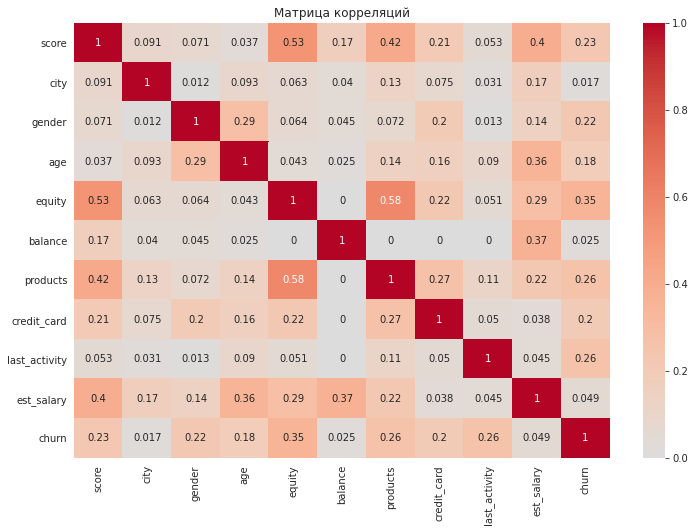

In [32]:
sns.heatmap(correlation.phik_matrix(interval_cols = ['score', 
                                                     'age', 
                                                     'balance', 
                                                     'est_salary']), 
            cmap='coolwarm', center=0, annot=True)
plt.title('Матрица корреляций');

Шкала Чеддока:
- 0,1 - 0,3 слабая связь;
- 0,3 - 0,5 умеренная связь;
- 0,5 - 0,7 заметная связь;
- 0,7 - 0,9 высокая связь;
- 0,9 - 0,99 весьма высокая связь.

Заметная связь наблюдается между признаками "количество баллов собственности" и "баллы кредитного скоринга".<br>
А также между признаками "количество баллов собственности" и "количество продуктов, которыми пользуется клиент".<br>
В остальном связь слабее.

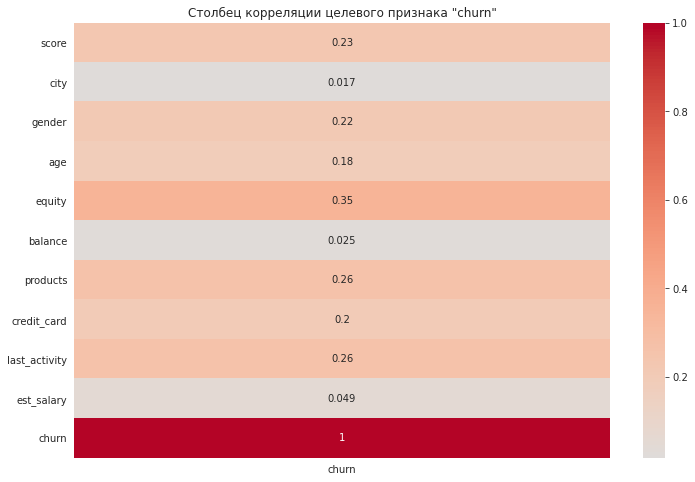

In [33]:
sns.heatmap(correlation.phik_matrix(interval_cols = ['score', 
                                                     'age', 
                                                     'balance', 
                                                     'est_salary'])[['churn']], 
            cmap='coolwarm', center=0, annot=True)
plt.title('Cтолбец корреляции целевого признака "churn"');

С оттоком наибольшую (и умеренную) связь имеет опять же признак "количество баллов собственности".<br>
Вовсе связь с оттоком отсутствует у признаков "город", "баланс", "заработная плата клиента".<br>
У остальных признаков связь слабая.

### Проверка статистических гипотез

Для обеих гипотез будем использовать t-тест:
1. Генеральные совокупности не должны зависеть друг от друга - ✔️ не зависят.
2. Выборочные средние должны быть нормально распределены - это условие не препятствие. Благодаря ЦПТ, если размер выборки составляет хотя бы несколько десятков значений, выборочные средние, которые можно получить из одной и той же генеральной совокупности, будут распределены нормально вокруг истинного среднего этой совокупности.
3. Дисперсии рассматриваемых генеральных совокупностей должны быть равны - будем использовать дополнительный параметр equal_var=False, т.к. выборки достаточно велики, чтобы и по отдельности точно оценить дисперсию каждой генеральной совокупности. Их объединение не сильно увеличит точность оценки дисперсии. А если дисперсии и правда разные, то такое объединение только исказит картину.

#### Гипотеза о равенстве среднего дохода клиентов, которые ушли и теми, которые остались

In [34]:
sample_1 = df[df['churn'] == 1]['est_salary']
sample_2 = df[df['churn'] == 0]['est_salary']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var=False)
# проведем стат. тест о равенстве доходов между двумя группами

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.8354803526840116
Не получилось отвергнуть нулевую гипотезу


Значение p-value показывает: вероятность случайно получить такое или большее различие равна почти 83,5%. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между доходами клиентов которые ушли и которые остались.

#### Гипотеза о равенстве среднего возраста клиентов, которые ушли и теми, которые остались

In [35]:
sample_1 = df[df['churn'] == 1]['age']
sample_2 = df[df['churn'] == 0]['age']

alpha = 0.05 # уровень статистической значимости
# если p-value окажется меньше него, отвергнем гипотезу

results = st.ttest_ind(sample_1, sample_2, equal_var=False)
# проведем стат. тест о равенстве среднего возраста между двумя группами

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 7.536127357312234e-08
Отвергаем нулевую гипотезу


Можно с уверенностью сказать, что средний возраст клиентов оставшихся и ушедших значимо отличается.

### Подведение промежуточных итогов

На данном этапе выберем признаки, которые лягут в основу сегментации - выбор сделаем по результатам EDA, корреляции и гипотез.

В зоне наибольшего оттока оказались клиенты:
- с баллами кредитного скоринга 820-900;
- в возрасте 25-36 лет, а также в возрасте 50-61 года;
- мужчины;
- имеющие 4 балла собственности и более;
- использущие 3 и более продукта банка;
- без кредитной карты.

### Сегментация

Выделим не менее 3х сегментов (от 500 клиентов на сегмент), в которых отток наблюдается больше, чем в среднем по банку. По результатам работы в прошлых блоках выделенные признаки будут проранжированы и определены их интервалы, включающие наибольший процент оттока клиентов.

В основу первого сегмента возьмем признак: 4 балла собственности и более, т.к. этот признак показал сильную связь на этапе корреляции.
В этот сегмент также добавим признаки: мужчина с баллами кредитного скоринга 820-900.

In [36]:
s1 = df.loc[(df['equity'] >= 4) & (df['gender'] == 'М') 
                  & (df['score'] >= 820) & (df['score'] <= 900)]
print(f"Количество клиентов в сегменте: {s1['userid'].count()}.")
print("Количество отточных клиентов в сегменте: "
      f"{s1[s1['churn'] == 1]['userid'].count()}.")
print("Уровень оттока в сегменте: "
      f"{(s1[s1['churn'] == 1]['userid'].count()/s1['userid'].count()*100).round(2)}%.")

Количество клиентов в сегменте: 1055.
Количество отточных клиентов в сегменте: 431.
Уровень оттока в сегменте: 40.85%.


Для второго сегмента рассмотрим клиентов в возрасте 25-36 лет без кредитной карты.

In [37]:
s2 = df.loc[(df['credit_card'] == 0)  
                  & (df['age'] >= 25) & (df['age'] <= 36)]
print(f"Количество клиентов в сегменте: {s2['userid'].count()}.")
print("Количество отточных клиентов в сегменте: "
      f"{s2[s2['churn'] == 1]['userid'].count()}.")
print("Уровень оттока в сегменте: "
      f"{(s2[s2['churn'] == 1]['userid'].count()/s2['userid'].count()*100).round(2)}%.")

Количество клиентов в сегменте: 939.
Количество отточных клиентов в сегменте: 320.
Уровень оттока в сегменте: 34.08%.


Третий сегмент будет включать в себя мужчин в возрасте 50-61 год.

In [38]:
s3 = df.loc[(df['gender'] == 'М') 
                  & (df['age'] >= 50) & (df['age'] <= 61)]
print(f"Количество клиентов в сегменте: {s3['userid'].count()}.")
print("Количество отточных клиентов в сегменте: "
      f"{s3[s3['churn'] == 1]['userid'].count()}.")
print("Уровень оттока в сегменте: "
      f"{(s3[s3['churn'] == 1]['userid'].count()/s3['userid'].count()*100).round(2)}%.")

Количество клиентов в сегменте: 819.
Количество отточных клиентов в сегменте: 267.
Уровень оттока в сегменте: 32.6%.


В четвертый сегмент включим клиентов, которые пользуются 3-мя продуктами банка и более. Возраст: 25-36 лет.

In [39]:
s4 = df.loc[(df['products'] >= 3)
            & (df['age'] >= 25) & (df['age'] <= 36)]
print(f"Количество клиентов в сегменте: {s4['userid'].count()}.")
print("Количество отточных клиентов в сегменте: "
      f"{s4[s4['churn'] == 1]['userid'].count()}.")
print("Уровень оттока в сегменте: "
      f"{(s4[s4['churn'] == 1]['userid'].count()/s4['userid'].count()*100).round(2)}%.")

Количество клиентов в сегменте: 514.
Количество отточных клиентов в сегменте: 223.
Уровень оттока в сегменте: 43.39%.


### Приоритизация сегментов с формированием рекомендаций

В первую очередь рекомендую обратить внимание на сегмент №2 (клиентов в сегменте 939, уровень оттока 34.08%).<br>
Признаки: возраст 25-36 лет, отсутствие кредитной карты.<br>
Рекомендация: провести рекламную компанию по кредитным картам, например запустить мини-игру прямо внутри приложения, которая также поможет разобраться пользователю в плюсах владения кредитной картой или для ускорения процесса ограничиться почтовой рассылкой.<br>
Этот сегмент я выделяю в первую очередь по причине того, что его при необходимости можно достаточно быстро обработать.

А во вторую и третюю очередь я бы выделила сегменты №1 и №4 для более глубокой дальнейшей проработки:

Сегмент №1 (клиентов в сегменте 1055, уровень оттока 40.85%).<br>
Признаки: 4 балла собственности и более, мужчина, баллы кредитного скоринга 820-900.<br>
Рекомендация: рассмотреть возможность спецпредложений по страхованию для таких клиентов, например в виде повышенного кэшбека.

Сегмент №4 (клиентов в сегменте 514, уровень оттока 43.39%).<br>
Признаки: использование 3х и более продуктов банка, возраст 25-36 лет.<br>
Рекомендация: проверить обратную связь от таких клиентов по непопулярным продуктам. Вполне возможно, что дело в качестве этих продуктов. Пользователи с широкими потребностями не удовлетворены предлагаемыми банком услугами и скорее всего такие опции нуждаются в усовершенствовании.

## Материалы

<a href='https://drive.google.com/file/d/1PAUjMVu94v0tdNUC-Iy1oS6ai0lS-DBK/view?usp=sharing'>Презентация</a>

<a href='https://public.tableau.com/views/Banks_16901969192180/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link'>Дашборд</a>